In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lr-dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv
/kaggle/input/lr-dataset/creditcard.csv
/kaggle/input/lr-dataset/adult/adult.data
/kaggle/input/lr-dataset/adult/adult.names
/kaggle/input/lr-dataset/adult/Index
/kaggle/input/lr-dataset/adult/old.adult.names
/kaggle/input/lr-dataset/adult/adult.test


# Libraries

In [7]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# telco dataset

In [8]:
class TelcoChurnAnalysis:
    def __init__(self):
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.base_models = []
        self.meta_model = None
        
    def preprocess_data(self, data_path: str) -> Tuple[np.ndarray, np.ndarray]:
        """
        Preprocess the Telco dataset
        """
        # Load data
        df = pd.read_csv(data_path)
        
        # Remove customer ID as it's not a feature
        df = df.drop('customerID', axis=1)
        
        # Convert 'TotalCharges' to numeric, handling empty spaces
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
        
        # Handle missing values
        numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
        categorical_columns = [col for col in df.columns if col not in numeric_columns + ['Churn']]
        
        # Impute missing values
        numeric_imputer = SimpleImputer(strategy='mean')
        df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])
        
        # Encode categorical variables
        for column in categorical_columns:
            self.label_encoders[column] = LabelEncoder()
            df[column] = self.label_encoders[column].fit_transform(df[column])
        
        # Encode target variable
        df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
        
        # Scale numeric features
        df[numeric_columns] = self.scaler.fit_transform(df[numeric_columns])
        
        # Split features and target
        X = df.drop('Churn', axis=1).values
        y = df['Churn'].values
        
        return X, y
    
    def create_bagging_datasets(self, X: np.ndarray, y: np.ndarray, n_bags: int = 9) -> List[Tuple[np.ndarray, np.ndarray]]:
        """
        Create bagging datasets using sampling with replacement
        """
        bagging_datasets = []
        n_samples = X.shape[0]
        
        for _ in range(n_bags):
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            bagging_datasets.append((X[indices], y[indices]))
            
        return bagging_datasets
    
    def train_base_models(self, bagging_datasets: List[Tuple[np.ndarray, np.ndarray]]) -> None:
        """
        Train base logistic regression models with different regularization settings
        """
        regularization_params = [
            {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'},
            {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'},
            {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'},
            {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'},
            {'C': 0.5, 'penalty': 'l2', 'solver': 'lbfgs'},
            {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'},
            {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'},
            {'C': 0.5, 'penalty': 'l2', 'solver': 'newton-cg'},
            {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
        ]
        
        self.base_models = []
        for (X_bag, y_bag), params in zip(bagging_datasets, regularization_params):
            model = LogisticRegression(**params, random_state=42, max_iter=1000)
            model.fit(X_bag, y_bag)
            self.base_models.append(model)
    
    def train_meta_model(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Train meta model for stacking
        """
        # Generate meta-features
        meta_features = self.get_meta_features(X)
        
        # Train meta model
        self.meta_model = LogisticRegression(random_state=42)
        self.meta_model.fit(meta_features, y)
    
    def get_meta_features(self, X: np.ndarray) -> np.ndarray:
        """
        Generate meta-features from base models' predictions
        """
        meta_features = np.column_stack([
            model.predict_proba(X)[:, 1] for model in self.base_models
        ])
        return meta_features
    
    def majority_vote_predict(self, X: np.ndarray) -> np.ndarray:
        """
        Make predictions using majority voting
        """
        predictions = np.column_stack([
            model.predict(X) for model in self.base_models
        ])
        return np.apply_along_axis(
            lambda x: np.bincount(x.astype(int)).argmax(),
            axis=1,
            arr=predictions
        )
    
    def stacking_predict(self, X: np.ndarray) -> np.ndarray:
        """
        Make predictions using stacking
        """
        meta_features = self.get_meta_features(X)
        return self.meta_model.predict(meta_features)
    
    def evaluate_models(self, X_test: np.ndarray, y_test: np.ndarray) -> Dict:
        """
        Evaluate all models and return performance metrics
        """
        results = {
            'base_models': [],
            'voting': {},
            'stacking': {}
        }
        
        # Evaluate base models
        for model in self.base_models:
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]
            
            results['base_models'].append({
                'accuracy': accuracy_score(y_test, y_pred),
                'sensitivity': recall_score(y_test, y_pred),
                'specificity': recall_score(y_test, y_pred, pos_label=0),
                'precision': precision_score(y_test, y_pred),
                'f1': f1_score(y_test, y_pred),
                'auroc': roc_auc_score(y_test, y_prob),
                'aupr': average_precision_score(y_test, y_prob)
            })
        
        # Evaluate voting ensemble
        y_pred_vote = self.majority_vote_predict(X_test)
        results['voting'] = {
            'accuracy': accuracy_score(y_test, y_pred_vote),
            'sensitivity': recall_score(y_test, y_pred_vote),
            'specificity': recall_score(y_test, y_pred_vote, pos_label=0),
            'precision': precision_score(y_test, y_pred_vote),
            'f1': f1_score(y_test, y_pred_vote),
            'auroc': roc_auc_score(y_test, self.get_meta_features(X_test).mean(axis=1)),
            'aupr': average_precision_score(y_test, self.get_meta_features(X_test).mean(axis=1))
        }
        
        # Evaluate stacking ensemble
        y_pred_stack = self.stacking_predict(X_test)
        y_prob_stack = self.meta_model.predict_proba(self.get_meta_features(X_test))[:, 1]
        results['stacking'] = {
            'accuracy': accuracy_score(y_test, y_pred_stack),
            'sensitivity': recall_score(y_test, y_pred_stack),
            'specificity': recall_score(y_test, y_pred_stack, pos_label=0),
            'precision': precision_score(y_test, y_pred_stack),
            'f1': f1_score(y_test, y_pred_stack),
            'auroc': roc_auc_score(y_test, y_prob_stack),
            'aupr': average_precision_score(y_test, y_prob_stack)
        }
        
        return results
    
    def plot_violin_metrics(self, results: Dict) -> None:
        """
        Create violin plots for base model metrics
        """
        metrics = ['accuracy', 'sensitivity', 'specificity', 'precision', 'f1', 'auroc', 'aupr']
        data = []
        
        for metric in metrics:
            values = [model[metric] for model in results['base_models']]
            data.extend([(metric, val) for val in values])
        
        df_plot = pd.DataFrame(data, columns=['Metric', 'Value'])
        
        plt.figure(figsize=(12, 6))
        sns.violinplot(data=df_plot, x='Metric', y='Value')
        plt.xticks(rotation=45)
        plt.title('Distribution of Performance Metrics Across Base Models')
        plt.tight_layout()
        plt.show()

    def print_comparison_table(self, results: Dict) -> None:
        """
        Print comparison table of model performances
        """
        metrics = ['accuracy', 'sensitivity', 'specificity', 'precision', 'f1', 'auroc', 'aupr']
        
        # Calculate mean and std for base models
        base_stats = {}
        for metric in metrics:
            values = [model[metric] for model in results['base_models']]
            base_stats[metric] = f"{np.mean(values):.3f} ± {np.std(values):.3f}"
        
        # Create comparison table
        rows = []
        rows.append(["LR*"] + [base_stats[m] for m in metrics])
        rows.append(["Voting ensemble"] + [f"{results['voting'][m]:.3f}" for m in metrics])
        rows.append(["Stacking ensemble"] + [f"{results['stacking'][m]:.3f}" for m in metrics])
        
        # Print table
        print("\nPerformance on Test set:")
        print(pd.DataFrame(rows, columns=['Model'] + metrics).to_string(index=False))


# calculate

Loading and preprocessing data...
Creating bagging datasets...
Training base models...
Training meta model...
Evaluating models...
Generating visualizations...


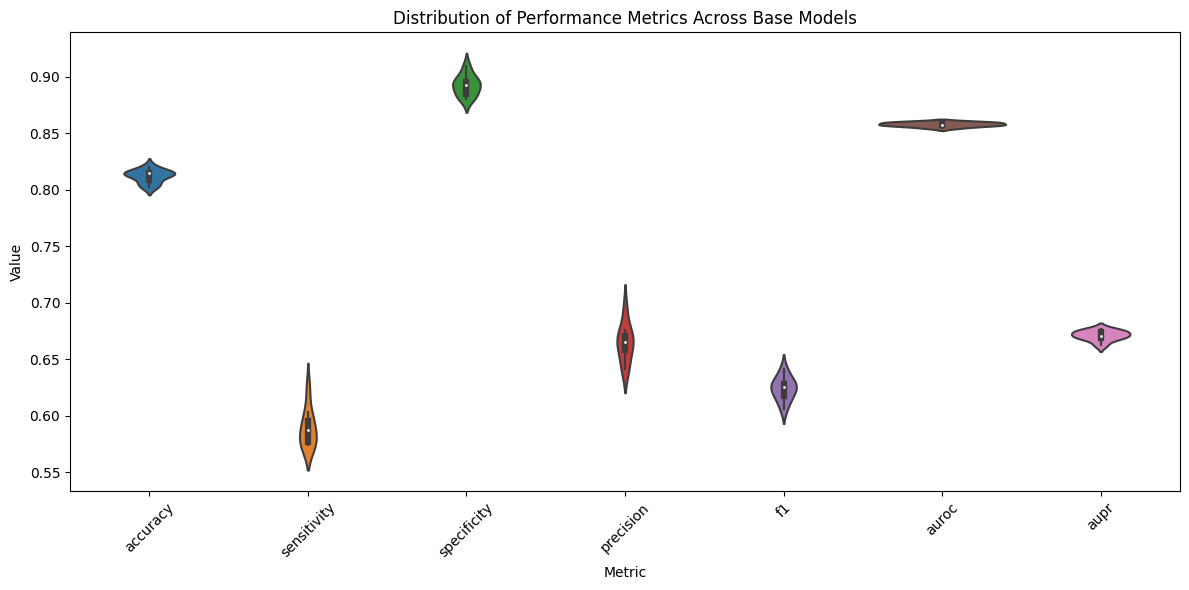


Performance on Test set:
            Model      accuracy   sensitivity   specificity     precision            f1         auroc          aupr
              LR* 0.812 ± 0.005 0.589 ± 0.016 0.893 ± 0.009 0.664 ± 0.016 0.624 ± 0.010 0.858 ± 0.002 0.671 ± 0.004
  Voting ensemble         0.813         0.590         0.894         0.667         0.626         0.860         0.675
Stacking ensemble         0.814         0.587         0.896         0.670         0.626         0.860         0.677


In [9]:
# Main execution
def main():
    # Initialize the analysis
    analysis = TelcoChurnAnalysis()
    
    # Load and preprocess data
    print("Loading and preprocessing data...")
    X, y = analysis.preprocess_data('/kaggle/input/lr-dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv')
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    # Create bagging datasets
    print("Creating bagging datasets...")
    bagging_datasets = analysis.create_bagging_datasets(X_train, y_train)
    
    # Train base models
    print("Training base models...")
    analysis.train_base_models(bagging_datasets)
    
    # Train meta model
    print("Training meta model...")
    analysis.train_meta_model(X_val, y_val)
    
    # Evaluate models
    print("Evaluating models...")
    results = analysis.evaluate_models(X_test, y_test)
    
    # Plot results
    print("Generating visualizations...")
    analysis.plot_violin_metrics(results)
    analysis.print_comparison_table(results)

if __name__ == "__main__":
    main()